<a href="https://colab.research.google.com/github/rhodes-byu/RF-Proximities-Workshop/blob/main/demo.ipynb" target="_blank">
    <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>



# Random Forest Proximities and Their Applications in Data Science

## Intro

In this demo, we will cover the basics of random forests (RF), focusing primarily on random forest proximities. Proximities form a supervised similarity measure that serve as the basis for a variety of applications. Specifically, we will be covering the use of RF proximities for visualization for data exploration, missing data imputation, outlier detecion, and ...

### Installation and Imports
Although viewed by Leo Breiman (random forest's primary author) as one of the most important aspects of random forests, Scikit-Learn's implementation of random forests does not implement them!  We will thus be relying on the RF-GAP-Python package to generate proximities for our applications. The installation is done by running the below cell:

In [121]:
# !pip install git+https://github.com/jakerhodes/RF-GAP-Python

In [122]:
from rfgap import RFGAP, impute
from sklearn.model_selection import train_test_split
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.datasets import fetch_openml
from sklearn.metrics import accuracy_score
from sklearn.manifold import MDS

#### Loading the Data
First we will read in the `Titanic` dataset using `fetch_openml`. The dataset contains information about passengers on the Titanic, including items such as their name, sex, class, and whether they survived or not.

In [123]:
# Read in Titanic
titanic = fetch_openml('titanic', version=1, as_frame=True)

In [124]:
titanic.keys()

dict_keys(['data', 'target', 'frame', 'categories', 'feature_names', 'target_names', 'DESCR', 'details', 'url'])

In [125]:
titanic.data.head()

,pclass,name,sex,age,sibsp,parch,ticket,fare,cabin,embarked,boat,body,home.dest
0,1,"Allen, Miss. Elisabeth Walton",female,29.0000,0,0,24160,211.3375,B5,S,2,NaN,"St Louis, MO"
1,1,"Allison, Master. Hudson Trevor",male,0.9167,1,2,113781,151.5500,C22 C26,S,11,NaN,"Montreal, PQ / Chesterville, ON"
2,1,"Allison, Miss. Helen Loraine",female,2.0000,1,2,113781,151.5500,C22 C26,S,NaN,NaN,"Montreal, PQ / Chesterville, ON"
3,1,"Allison, Mr. Hudson Joshua Creighton",male,30.0000,1,2,113781,151.5500,C22 C26,S,NaN,135.0,"Montreal, PQ / Chesterville, ON"
4,1,"Allison, Mrs. Hudson J C (Bessie Waldo Daniels)",female,25.0000,1,2,113781,151.5500,C22 C26,S,NaN,NaN,"Montreal, PQ / Chesterville, ON"


In [126]:
titanic.data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1309 entries, 0 to 1308
Data columns (total 13 columns):
 #   Column     Non-Null Count  Dtype   
---  ------     --------------  -----   
 0   pclass     1309 non-null   int64   
 1   name       1309 non-null   object  
 2   sex        1309 non-null   category
 3   age        1046 non-null   float64 
 4   sibsp      1309 non-null   int64   
 5   parch      1309 non-null   int64   
 6   ticket     1309 non-null   object  
 7   fare       1308 non-null   float64 
 8   cabin      295 non-null    object  
 9   embarked   1307 non-null   category
 10  boat       486 non-null    object  
 11  body       121 non-null    float64 
 12  home.dest  745 non-null    object  
dtypes: category(2), float64(3), int64(3), object(5)
memory usage: 115.4+ KB


In [127]:
X = titanic.data.copy()
X.drop(['name', 'ticket', 'cabin', 'boat', 'body', 'home.dest'], axis=1, inplace=True)

# One-hot encoding of categorical variables
X_one_hot = pd.get_dummies(X, drop_first=False)

In [128]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1309 entries, 0 to 1308
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype   
---  ------    --------------  -----   
 0   pclass    1309 non-null   int64   
 1   sex       1309 non-null   category
 2   age       1046 non-null   float64 
 3   sibsp     1309 non-null   int64   
 4   parch     1309 non-null   int64   
 5   fare      1308 non-null   float64 
 6   embarked  1307 non-null   category
dtypes: category(2), float64(2), int64(3)
memory usage: 54.1 KB


Note that age, fare, and embarked have missing values. We can impute them using the RF-GAP proximities.

### Missing Value Imputation

Leo Breiman described two methods for random forest imputation. The first method does not actually use the random forest at all, but simply imputes using the mean, median, or most frequent category for an initial guess. The second method uses the random forest proximities to refine the imputation. Here is the original description:

---

**Random forests has two ways of replacing missing values.**

1. **Fast Method (Initial Guess)**

   - If the *m*th variable is **not categorical**, compute the **median** of all values of this variable in class *j*, then use this value to replace all missing values of the *m*th variable in class *j*.
   - If the *m*th variable is **categorical**, the replacement is the **most frequent non-missing** value in class *j*.
   - These replacement values are called **fills**.

2. **Proximity-Based Method (Refined Imputation)**

   - This method is **computationally more expensive** but has given better performance, even with large amounts of missing data.
   - It replaces missing values **only in the training set**.

   **Steps:**
   1. Perform a rough and inaccurate filling in of the missing values.
   2. Run a random forest and compute **proximities**.
   3. For a missing value:
      - If `x(m,n)` is a **missing continuous** value, estimate its fill as the **average** over the non-missing values of the *m*th variable, **weighted by the proximities** between the *n*th case and the cases with non-missing values.
      - If it is a **missing categorical** variable, replace it with the **most frequent non-missing** value, where **frequency is weighted by proximity**.
   4. **Iterate**:
      - Construct a new forest using the newly filled-in values.
      - Find new fills.
      - Repeat the process.

   - **Our experience is that 4–6 iterations are enough.**


In [129]:
X_train, X_test, y_train, y_test = train_test_split(X_one_hot, titanic.target, test_size=0.2, random_state=42)

In [130]:
X_train_imputed, X_test_imputed = impute.rfgap_impute(x = X_train, y = y_train, initialization = 'knn', x_test = X_test)

c:\Users\rhodes8\AppData\Local\miniconda3\envs\rf-workshop\lib\site-packages\rfgap\impute.py:105: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  groups = df.groupby(y)


In [131]:
X_missing = X_train.isna().sum(axis = 1)

<Axes: xlabel='age', ylabel='Sex'>

c:\Users\rhodes8\AppData\Local\miniconda3\envs\rf-workshop\lib\site-packages\seaborn\categorical.py:3399: UserWarning: 24.5% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
c:\Users\rhodes8\AppData\Local\miniconda3\envs\rf-workshop\lib\site-packages\seaborn\categorical.py:3399: UserWarning: 7.3% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
c:\Users\rhodes8\AppData\Local\miniconda3\envs\rf-workshop\lib\site-packages\seaborn\categorical.py:3399: UserWarning: 24.4% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


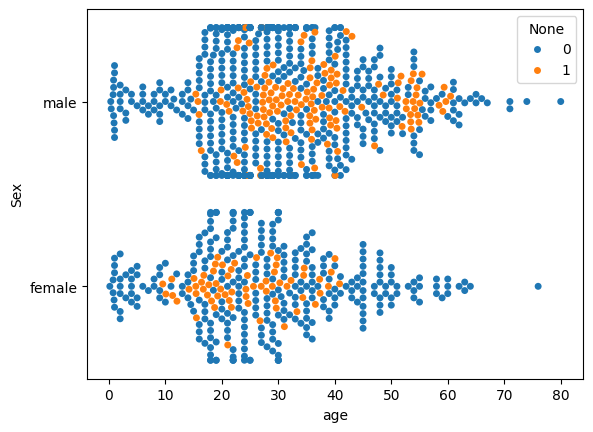

In [132]:
X_train_imputed_plot = X_train_imputed.copy()
X_train_imputed_plot['Sex'] = X_train_imputed_plot['sex_female'].map({1: 'female', 0: 'male'})
sns.swarmplot(data=X_train_imputed_plot, x='age', y='Sex', hue = X_missing)

In [133]:
# TODO: Review above see what to keep

## Training the RandomForest

The RF-GAP class is a wrapper around the `RandomForestClassifier` or `RandomForestRegressor` from `sklearn`. It takes most of the same parameters, but has the added benefit of the proximity construction and subsequent applications. As with other models in `sklearn`, we train using the `model.fit(x, y)` method, and make predictions using the `model.predict(x)` method. Aftwerward, we can evalute the random forest model using our metric of choice.

To include the computation of the out-of-bag accuracy, we need to include the `oob_score = True` argument. We can access the score using `model.oob_score_`.

In [134]:
rf = RFGAP(prox_method = 'rfgap', n_estimators = 500, oob_score = True, random_state = 42)
# Hint: RFGAP defaults to classification, include `y` as an argument or specifiy `prediction_type = 'regression'` for regression.

rf.fit(X_train_imputed, y_train)
print('OOB Score: ', rf.oob_score_)

OOB Score:  0.7956064947468959


### Predictions on the Test Set
As with other `sklearn` models, we can use the `predict` method to make predictions on the test set. The `predict_proba` method will return the predicted probabilities for each class.

In [135]:
yhat = rf.predict(X_test_imputed)
print(yhat)


['0' '1' '0' '0' '0' '0' '0' '0' '0' '1' '0' '0' '1' '0' '0' '0' '0' '1'
 '1' '0' '1' '0' '0' '1' '1' '1' '0' '1' '0' '1' '0' '1' '1' '1' '0' '0'
 '1' '0' '1' '0' '1' '0' '1' '0' '0' '1' '0' '1' '1' '1' '1' '0' '1' '1'
 '1' '0' '0' '0' '0' '1' '0' '0' '1' '0' '1' '1' '1' '0' '0' '0' '1' '0'
 '0' '0' '1' '0' '0' '1' '0' '1' '0' '0' '0' '1' '1' '0' '0' '1' '1' '1'
 '1' '0' '1' '0' '0' '0' '0' '1' '0' '1' '0' '1' '0' '0' '0' '0' '0' '0'
 '0' '1' '0' '0' '0' '1' '1' '1' '0' '0' '0' '1' '0' '0' '0' '0' '0' '1'
 '0' '1' '1' '0' '1' '1' '1' '0' '0' '1' '0' '0' '0' '0' '0' '0' '0' '1'
 '0' '1' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '1' '0' '0' '0' '0' '1'
 '0' '0' '1' '0' '0' '0' '0' '1' '1' '1' '1' '0' '1' '0' '1' '1' '1' '0'
 '1' '1' '0' '1' '0' '1' '0' '1' '1' '1' '0' '0' '0' '0' '0' '1' '0' '0'
 '1' '1' '0' '0' '0' '0' '0' '0' '1' '0' '0' '0' '0' '1' '0' '1' '0' '1'
 '1' '0' '1' '0' '1' '1' '1' '0' '0' '1' '0' '1' '1' '0' '0' '1' '0' '0'
 '0' '1' '0' '0' '0' '0' '1' '0' '0' '0' '0' '0' '0

In [136]:
print('Test Score: ', rf.score(X_test_imputed, y_test))

Test Score:  0.7938931297709924


Note the similarity between the test accuracy and OOB accuracy.

## Generating the proximities
The `RFGAP` class uses the built-in method `get_proximities` to generate the random forest proximities. By default, the RF-GAP proximities are generated across the full test set. Other options include the original and OOB versions of the proximities. 

As the RF-GAP proximities serves as weights (recall: $\hat{y_i}^{RF} = \sum_{j = 1}^{n}y_{j}p(i, j)$), each row of the proximity matrix sums to 1. 

In [137]:
prox_rfgap = rf.get_proximities()
prox_rfgap.sum(axis = 1)

matrix([[1.],
        [1.],
        [1.],
        ...,
        [1.],
        [1.],
        [1.]], shape=(1047, 1))

In [138]:
y_train_hot = pd.get_dummies(y_train, drop_first=False)

Proximity-based predicted probabilities

In [139]:
weighted_sum = prox_rfgap @ y_train_hot
print(weighted_sum)

[[0.88594041 0.11405959]
 [0.99571429 0.00428571]
 [0.03015075 0.96984925]
 ...
 [0.96488764 0.03511236]
 [0.34444444 0.65555556]
 [0.55276382 0.44723618]]


In [140]:
prox_predictions = np.argmax(weighted_sum, axis = 1)
oob_predictions = np.argmax(rf.oob_decision_function_, axis = 1)

In [141]:
np.sum(oob_predictions == prox_predictions)

np.int64(1046)

All of the proximity predictions match the OOB predictions!

### Visualization of the proximities

In [142]:
dir(rf)

['__abstractmethods__',
 '__annotations__',
 '__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__getitem__',
 '__getstate__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__iter__',
 '__le__',
 '__len__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__setstate__',
 '__sizeof__',
 '__sklearn_clone__',
 '__sklearn_tags__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_abc_impl',
 '_build_request_for_signature',
 '_check_feature_names',
 '_check_n_features',
 '_compute_oob_predictions',
 '_doc_link_module',
 '_doc_link_template',
 '_doc_link_url_param_generator',
 '_estimator_type',
 '_get_default_requests',
 '_get_doc_link',
 '_get_estimators_indices',
 '_get_in_bag_samples',
 '_get_metadata_request',
 '_get_oob_predictions',
 '_get_oob_samples',
 '_get_param_names',
 '_get_tags',
 '_make_estimator',
 '_more_tags',
 '_n_samp

In [143]:
rf.force_symmetric = True
rf.non_zero_diagonal = True

In [144]:
# rf.set_params(non_zero_diagonal = True, force_symmetric = True)
rfgap_symmetric = rf.get_proximities().toarray()
rf_distances = 1 - rfgap_symmetric

In [145]:
mds = MDS(n_components=2, dissimilarity='precomputed', random_state=42)
mds_emb = mds.fit_transform(rf_distances)

Text(0.5, 0.98, 'Proximity Visualization via MDS')

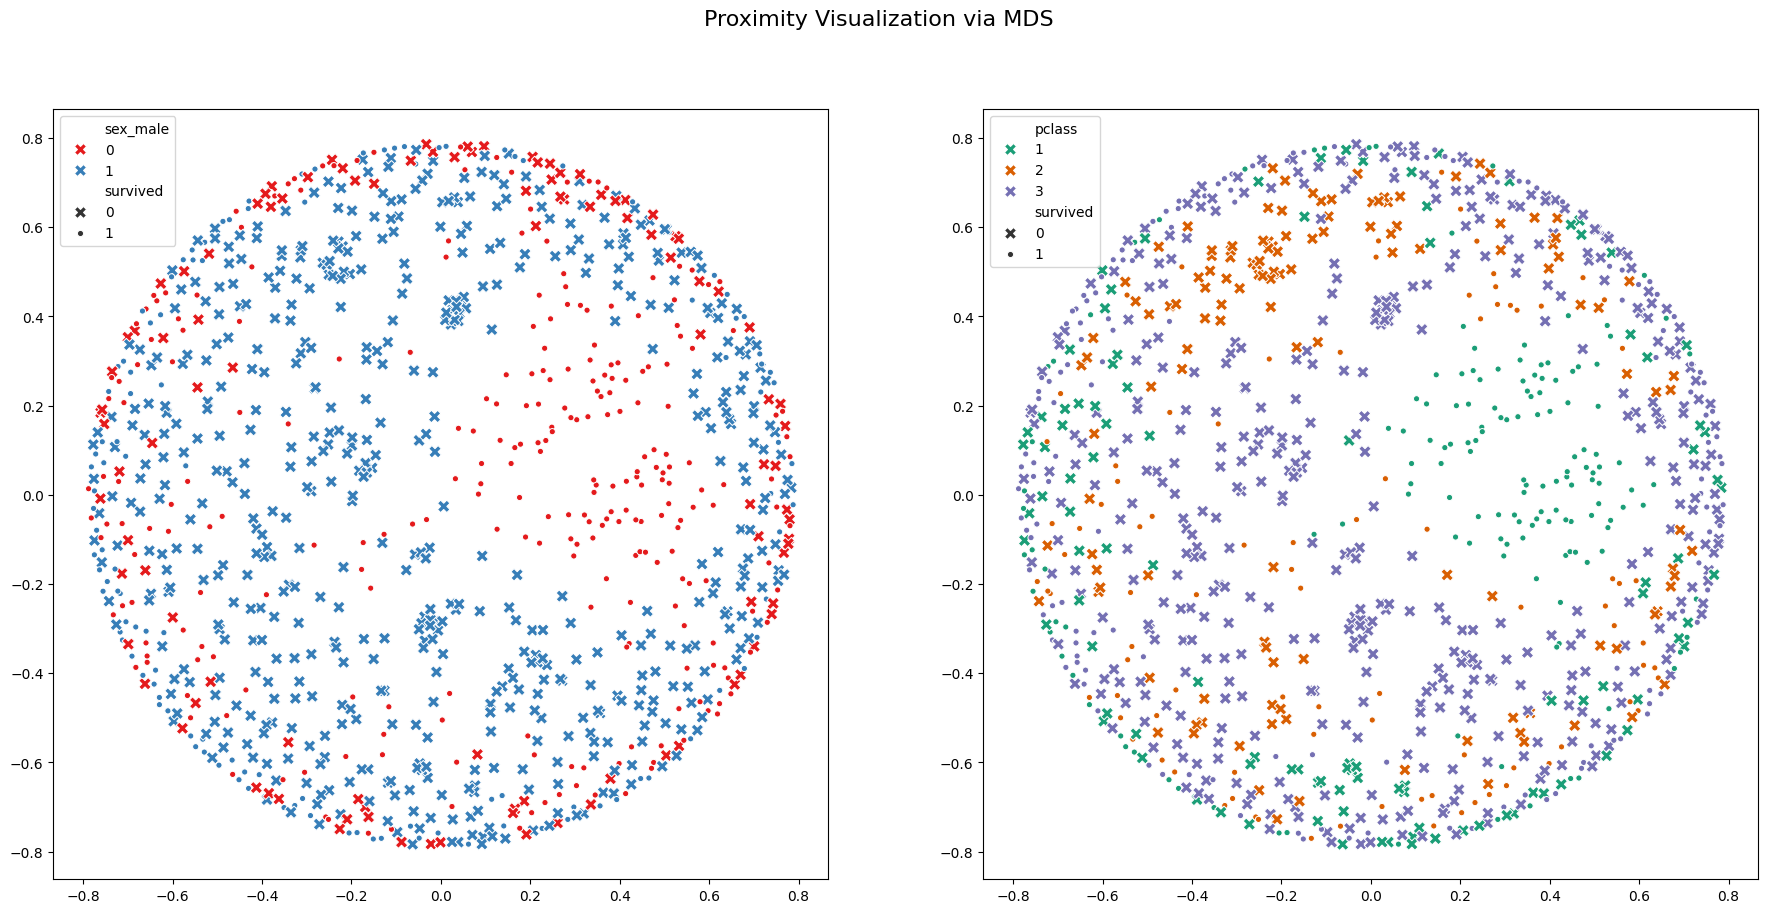

In [146]:
fig, axes = plt.subplots(1, 2, figsize=(22, 10))
markers = ['X', '.']
s = 80
sns.scatterplot(x=mds_emb[:, 0], y=mds_emb[:, 1], 
                hue=X_train_imputed.sex_male, style=y_train,
                palette='Set1', ax=axes[0], s=s,
                markers=markers)

sns.scatterplot(x=mds_emb[:, 0], y=mds_emb[:, 1], 
                hue=X_train_imputed.pclass, style=y_train, 
                palette='Dark2', ax=axes[1], s=s,
                markers=markers)


for ax in axes:
    ax.legend(loc='upper left')
fig.suptitle("Proximity Visualization via MDS", fontsize=16)

We can do better!  The Potential of Heat-diffusion for Affinity-based Trajectory Embedding or PHATE is a tool for visualizing high dimensional data. We can apply PHATE to the proximities for a better low-dimensional representation or embedding.

In [147]:
!pip install umap-learn

In [ ]:
from umap import UMAP
umap = UMAP(metric = 'precomputed', random_state = 42)

In [149]:
umap_emb = umap.fit_transform(rf_distances)

c:\Users\rhodes8\AppData\Local\miniconda3\envs\rf-workshop\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\rhodes8\AppData\Local\miniconda3\envs\rf-workshop\lib\site-packages\umap\umap_.py:1865: UserWarning: using precomputed metric; inverse_transform will be unavailable
  warn("using precomputed metric; inverse_transform will be unavailable")
c:\Users\rhodes8\AppData\Local\miniconda3\envs\rf-workshop\lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


Text(0.5, 0.98, 'Proximity Visualization via UMAP')

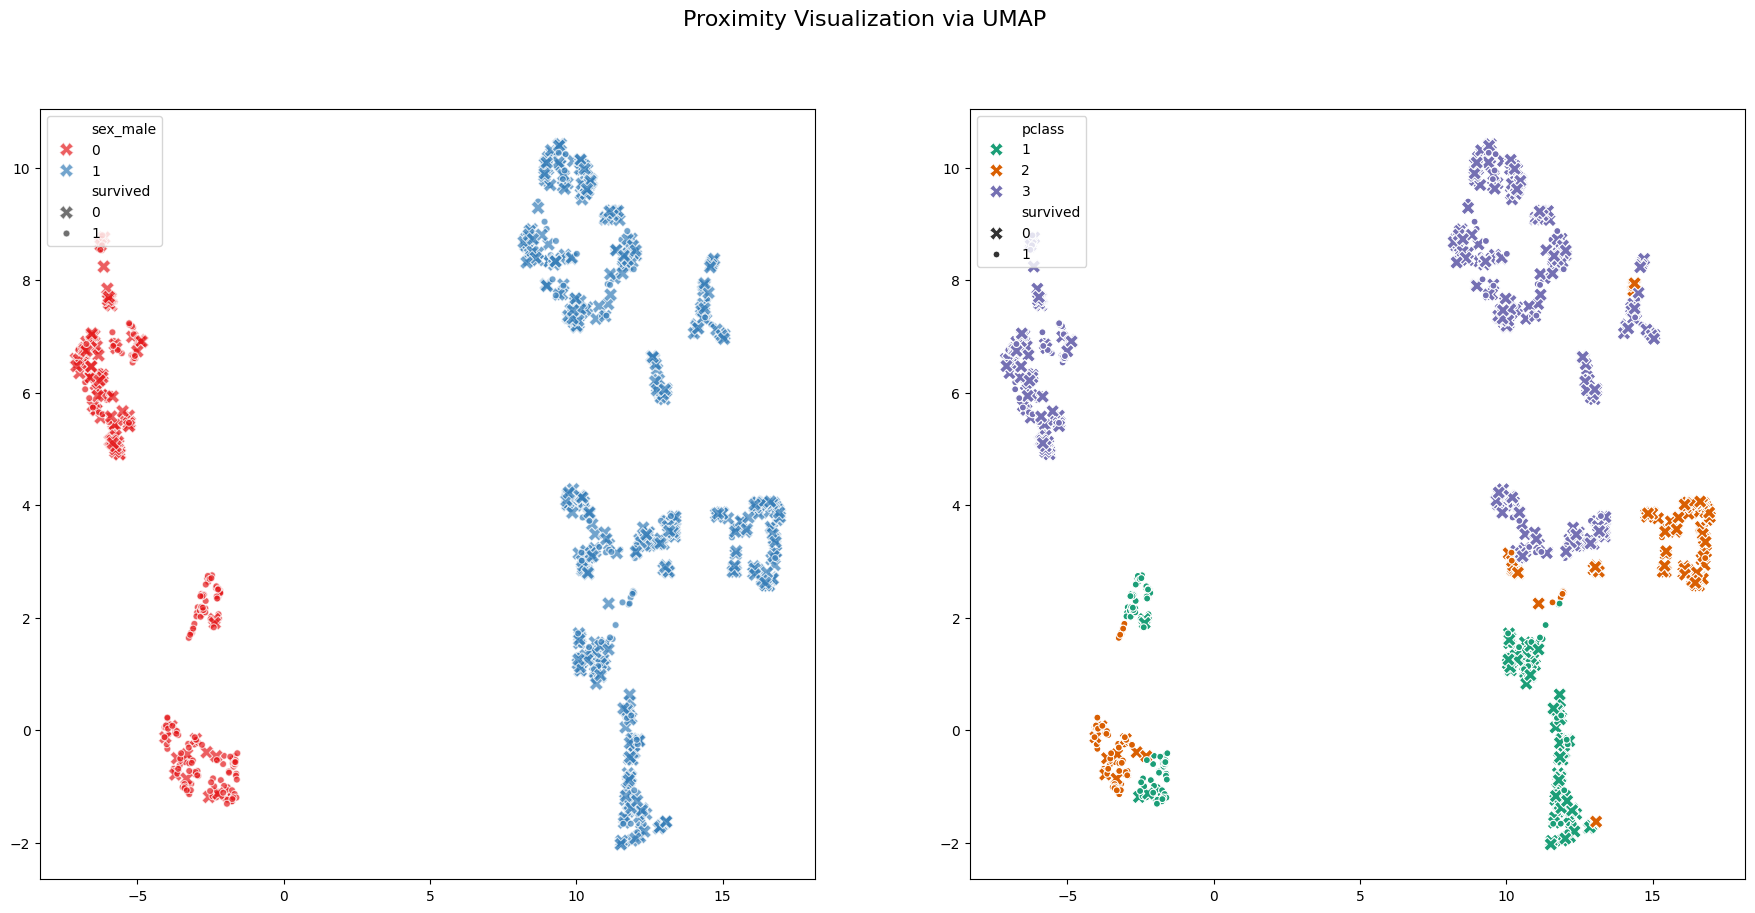

In [158]:
fig, axes = plt.subplots(1, 2, figsize=(22, 10))
markers = ['X', '.']
s = 100
sns.scatterplot(x=umap_emb[:, 0], y=umap_emb[:, 1], 
                hue=X_train_imputed.sex_male, style=y_train,
                palette='Set1', ax=axes[0], s=s,
                markers=markers, alpha = 0.7)

sns.scatterplot(x=umap_emb[:, 0], y=umap_emb[:, 1], 
                hue=X_train_imputed.pclass, style=y_train, 
                palette='Dark2', ax=axes[1], s=s,
                markers=markers)


for ax in axes:
    ax.legend(loc='upper left')
fig.suptitle("Proximity Visualization via UMAP", fontsize=16)

## Assessing outliers.

Outliers are generally defined as cases that are removed from the main body of the data. Translate this as: outliers are cases whose proximities to all other cases in the data are generally small. A useful revision is to define outliers relative to their class. Thus, an outlier in class *j* is a case whose proximities to all other class *j* cases are small.

Define the average proximity from case *n* in class *j* to the rest of the training data class *j* as:

$$
\bar{P}(n) = \sum_{\text{cl}(k)=j} \text{prox}^2(n, k)
$$

The raw outlier measure for case *n* is defined as:

$$
\text{nsample} / \bar{P}(n)
$$

This will be large if the average proximity is small. Within each class, find the median of these raw measures, and their absolute deviation from the median. Subtract the median from each raw measure, and divide by the absolute deviation to arrive at the final


In [ ]:
import numpy as np

def get_rf_outliers(y_train, prox_matrix, scaling = 'normalize'):
    """
    Compute class-relative outlier scores based on proximity matrix.

    Parameters:
    -----------
    y_train : pandas Series
        Class labels for training samples (e.g., '0', '1', ...)
    prox_matrix : scipy.sparse matrix or np.ndarray
        Square proximity matrix (n_samples x n_samples)

    Returns:
    --------
    outlier_scores : np.ndarray
        Standardized outlier scores (higher = more outlier-like)
    """
    y_train_arr = y_train.to_numpy()
    n_samples = len(y_train_arr)

    # Ensure matrix is dense
    if not isinstance(prox_matrix, np.ndarray):
        prox_dense = prox_matrix.toarray()
    else:
        prox_dense = prox_matrix

    # Step 1: Compute average squared proximities to same-class samples
    avg_prox = np.zeros(n_samples)
    for cls in np.unique(y_train_arr):
        idx = np.where(y_train_arr == cls)[0]
        prox_sub = prox_dense[np.ix_(idx, idx)]
        avg_prox[idx] = np.sum(prox_sub ** 2, axis=1)

    # Check this out
    if np.any(avg_prox == 0):
        print("Warning: Some samples have zero average proximity to same-class samples. This may affect outlier score calculation.")

    avg_prox[avg_prox == 0] = 1e-10

    # Step 2: Compute raw outlier scores
    raw_scores = n_samples / avg_prox


    # Step 3: Standardize within each class
    outlier_scores = np.zeros_like(raw_scores)
    for cls in np.unique(y_train_arr):
        idx = np.where(y_train_arr == cls)[0]
        class_scores = raw_scores[idx]

        median = np.median(class_scores)
        abs_dev = np.median(np.abs(class_scores - median))

        if abs_dev == 0:
            outlier_scores[idx] = 0
        else:
            outlier_scores[idx] = np.abs((class_scores - median)) / abs_dev

    if scaling == 'log':
        # Apply log scaling to outlier scores
        outlier_scores = np.log1p(outlier_scores)

    elif scaling == 'normalize':
        # Normalize outlier scores to [0, 1] range
        min_score = np.min(outlier_scores)
        max_score = np.max(outlier_scores)

        if max_score - min_score > 0:
            outlier_scores = (outlier_scores - min_score) / (max_score - min_score)
        else:
            outlier_scores = np.zeros_like(outlier_scores)

    return outlier_scores


In [162]:
outlier_scores = get_rf_outliers(y_train, prox_rfgap, scaling = 'normalize')


In [163]:
outlier_scores

array([2.40084441e-09, 3.61925020e-10, 1.50583335e-10, ...,
       8.47385691e-10, 1.88502103e-09, 3.11269518e-10], shape=(1047,))

Text(0.5, 1.0, 'Sizing by RF Outier Scores')

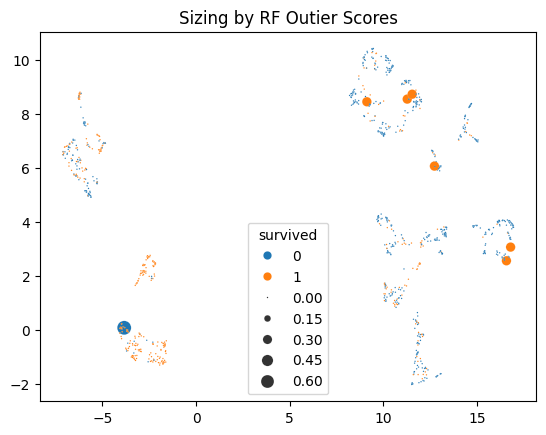

In [164]:
sns.scatterplot(x=umap_emb[:, 0], y=umap_emb[:, 1],
                size=np.log(outlier_scores + 1),
                sizes=(1, 100),
                markers=markers,
                hue=y_train,
                alpha=1)
plt.title("Sizing by RF Outier Scores")


In [167]:
!pip install plotly

  Using cached plotly-6.1.1-py3-none-any.whl.metadata (6.9 kB)
Using cached plotly-6.1.1-py3-none-any.whl (16.1 MB)

   ---------------------------------------- 0/2 [narwhals]
   ---------------------------------------- 0/2 [narwhals]
   ---------------------------------------- 0/2 [narwhals]
   ---------------------------------------- 0/2 [narwhals]
   ---------------------------------------- 0/2 [narwhals]
   -------------------- ------------------- 1/2 [plotly]
   -------------------- ------------------- 1/2 [plotly]
   -------------------- ------------------- 1/2 [plotly]
   -------------------- ------------------- 1/2 [plotly]
   -------------------- ------------------- 1/2 [plotly]
   -------------------- ------------------- 1/2 [plotly]
   -------------------- ------------------- 1/2 [plotly]
   -------------------- ------------------- 1/2 [plotly]
   -------------------- ------------------- 1/2 [plotly]
   -------------------- ------------------- 1/2 [plotly]
   ---------------

In [168]:
import plotly.express as px

fig = px.scatter(
    x=umap_emb[:, 0],
    y=umap_emb[:, 1],
    color=y_train.astype(str),
    size=np.log(outlier_scores + 1),
    size_max=30,
    labels={'x': 'UMAP 1', 'y': 'UMAP 2', 'color': 'Survived'},
    title="Sizing by RF Outlier Scores"
)
fig.show()


ValueError: Mime type rendering requires nbformat>=4.2.0 but it is not installed

In [155]:
## Bonus Material (MA, RF-PHATE, Time Series Classification)